# Image Representation in Computer Vision

In computer vision we tend to view images as a 3 dimensional object. Its 3 dimensions can be thought of as its width, height and the number of colour channels it has.

For example a 10x10px which is composed of the colour red, blue and green can be thought of as cuboid of shape 10x10x3. Where the 3 dimensions specify the component of the colour of the pixel in question. E.g.

Download the image found at

Saving android.jpg to android.jpg


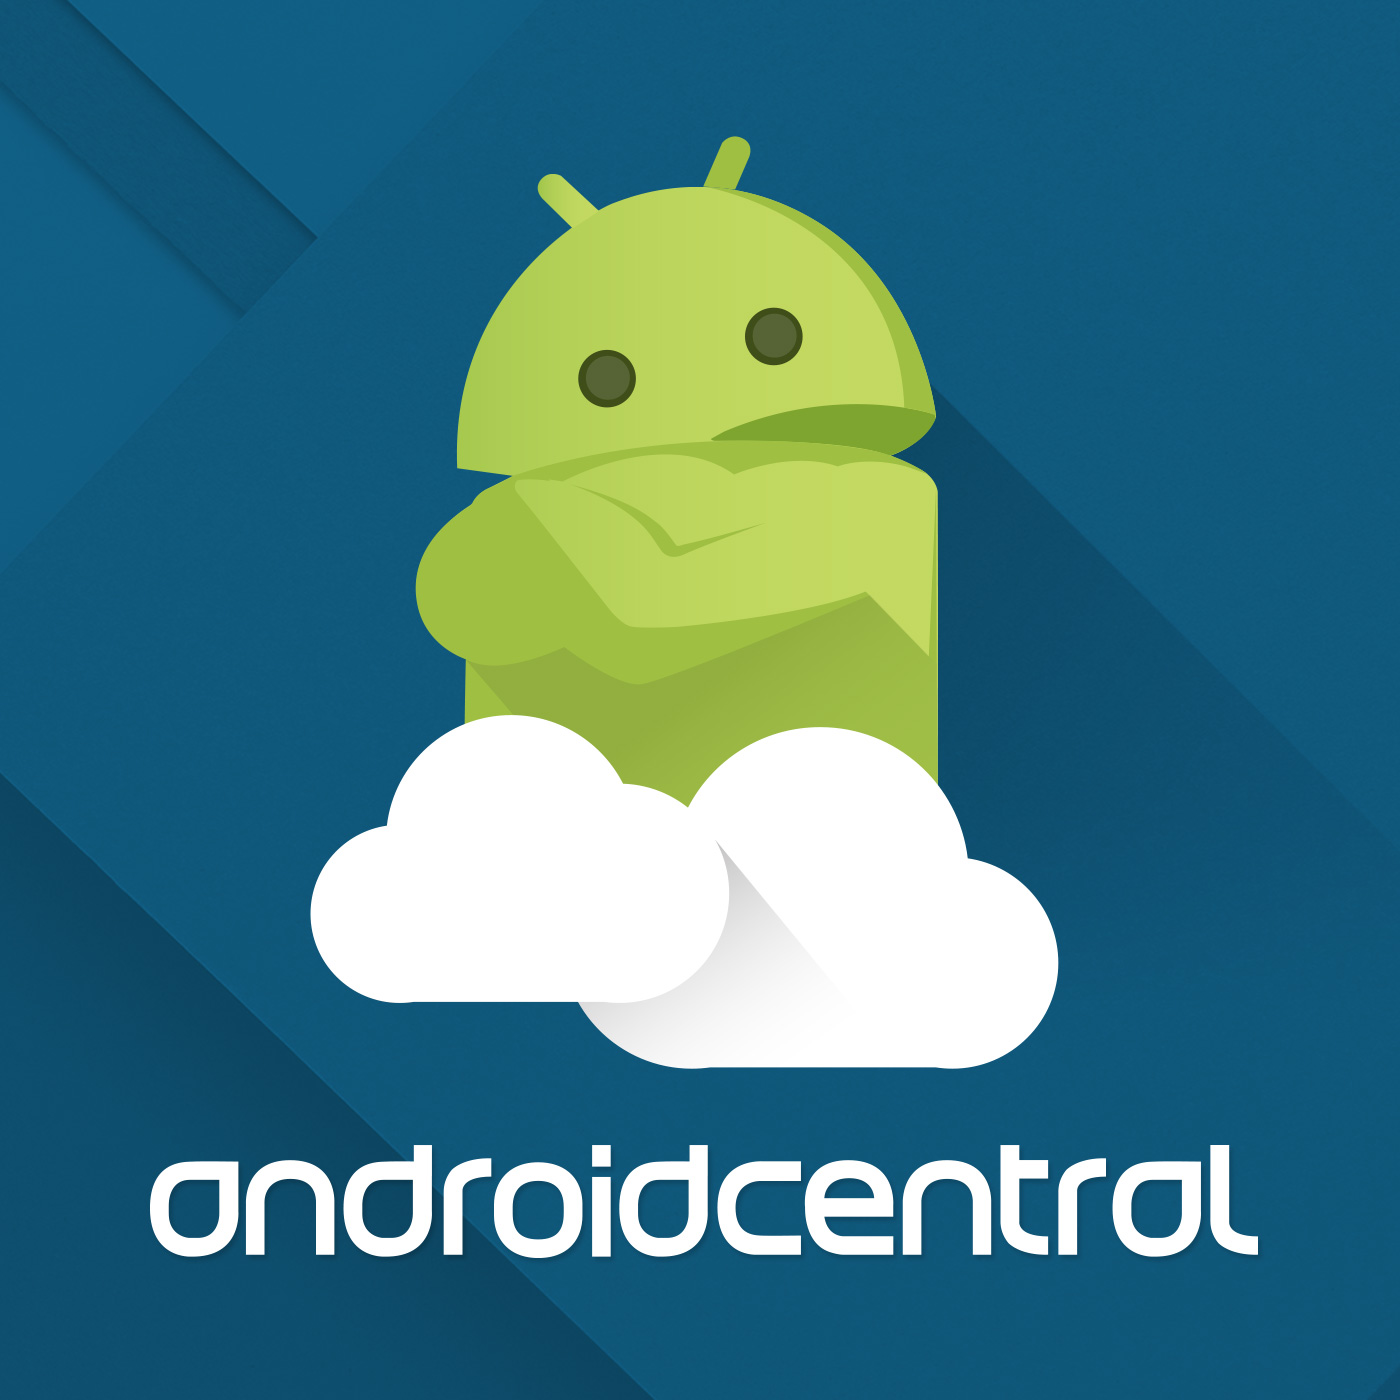

In [0]:
from IPython.display import Image
from google.colab import files

uploaded = files.upload()

Image('android.jpg', width=100, height=100)

If we select for a variety of different colour channels we get a decomposition of what the image is composed of. I.e. r, g, b.

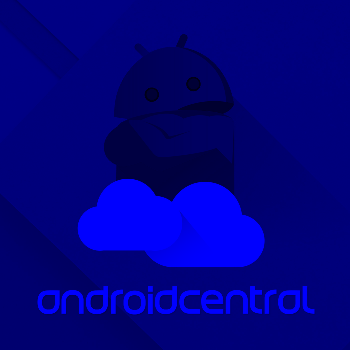

In [0]:
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread('android.jpg')
image = cv2.resize(image, (int(image.shape[1]*25/100), int(image.shape[0]*25/100)))

b = image.copy()
b[:, :, 1] = 0
b[:, :, 2] = 0
cv2_imshow(b)


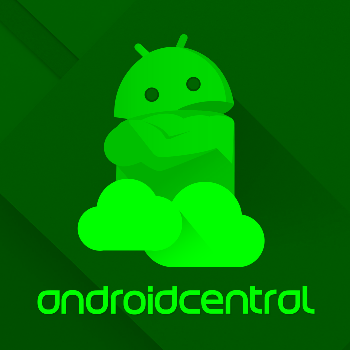

In [0]:
g = image.copy()
g[:, :, 0] = 0
g[:, :, 2] = 0
cv2_imshow(g)


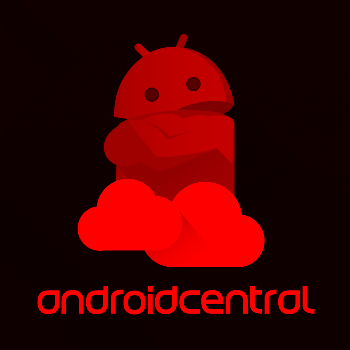

In [0]:
r = image.copy()
r[:, :, 0] = 0
r[:, :, 1] = 0
cv2_imshow(r)

Our final consideration for the theory of building a CNN for this workshop is in understanding filters. Filters provide the means by which we define images by a set of features we wish to isolate.

When we apply a filter we are reducing our image to some set of characteristics that we can define our classification by.

For example, a human face we might define by a set of two eyes, a mouth, a pair of ears, a head shape and then perhaps some other accessories e.g. facial hair, glasses, head hair etc.

In the following example we'll be looking at an example of a filter applied to an image to demonstrate how we can isolate features of an image to identify the image.

In [0]:
pip install pillow

In [0]:
import numpy as np
import scipy
import imageio
from scipy import ndimage

im = imageio.imread('android.jpg')
im = im.astype('int32')

dx = ndimage.sobel(im, 0)  # horizontal derivative



def display_img(img):
  imageio.imsave('sobel.jpg', img)
  image = cv2.imread('sobel.jpg')
  # image = cv2.resize(image, (int(image.shape[1]), int(image.shape[0])))
  cv2_imshow(image)

What we have just applied is what as known as a vertical sobel filter. This filter is a particularly famous filter which has its main use in edge detection. Let's have a look at the resulting image.

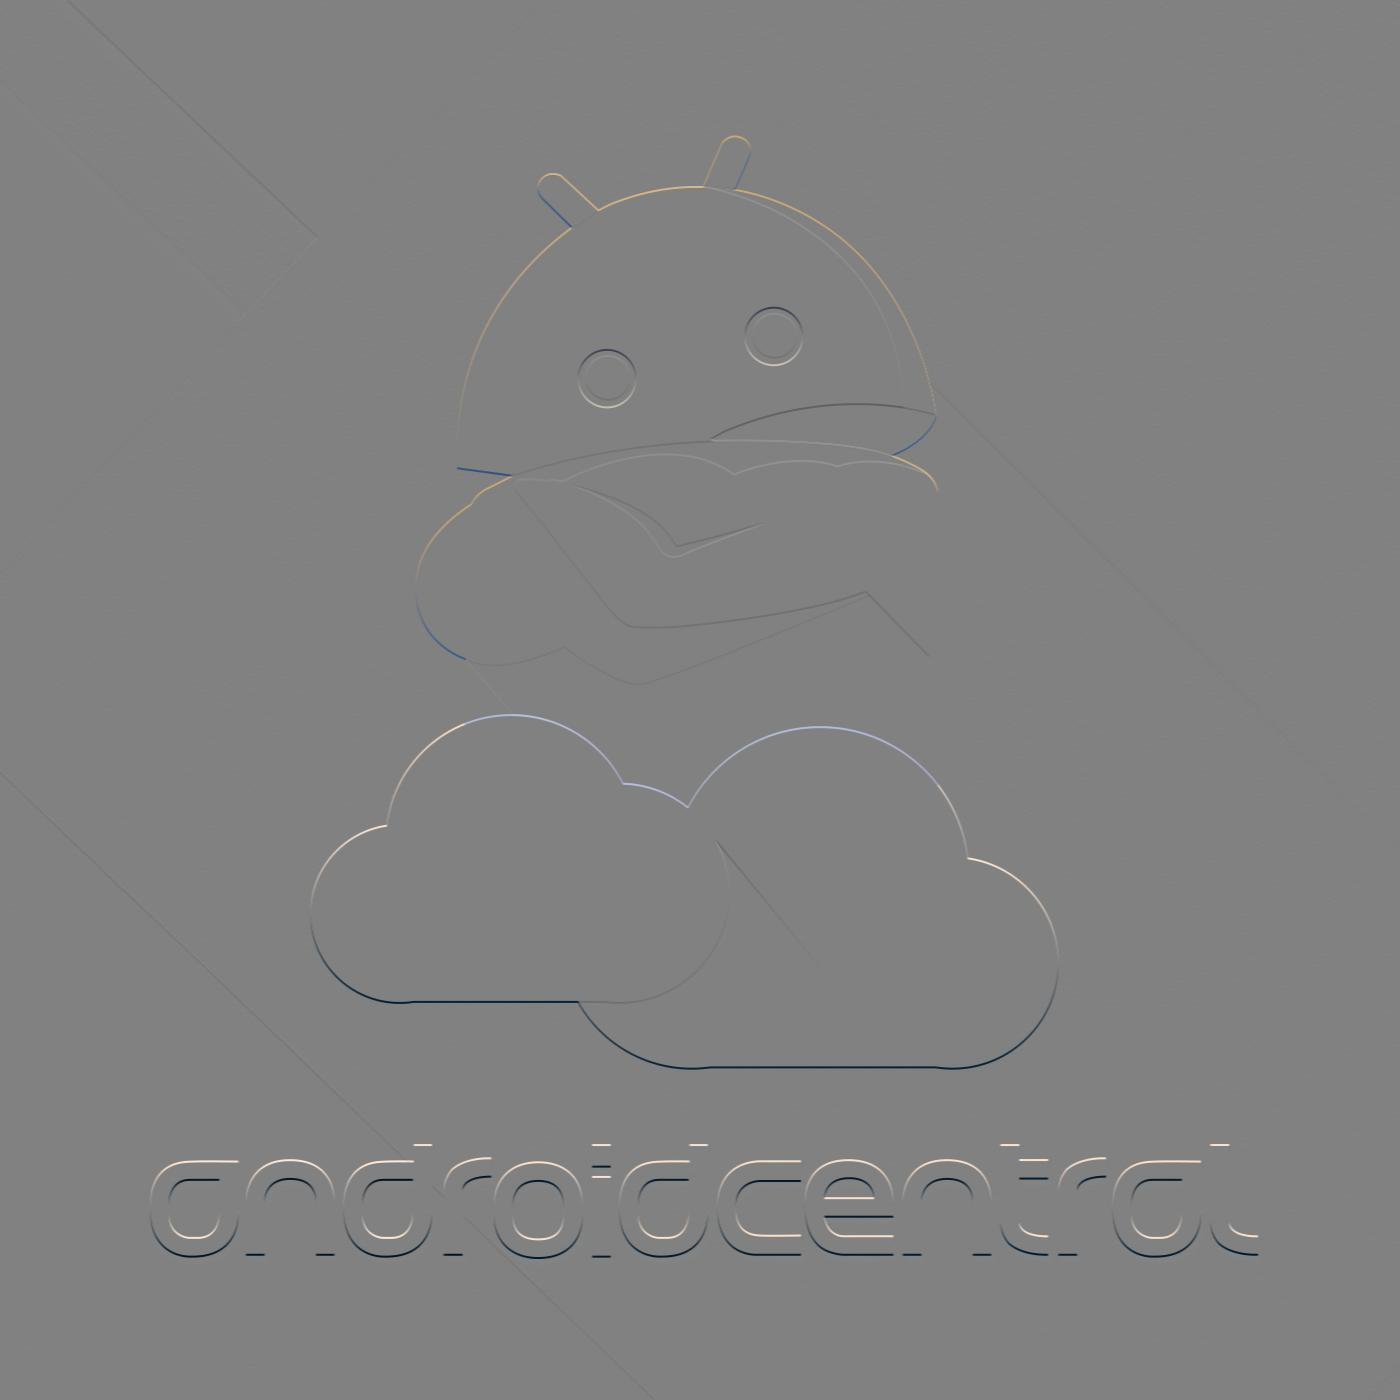

In [0]:
display_img(dx)

Note: the vertical elements of the image remain, yet the more horizontal points have been removed. The feature described by this filter is that of a vertical line. We have reduced our image to be described only by this very specific set of features.

Similarly we can apply a horizontal sobel filter to filter out our vertical lines.

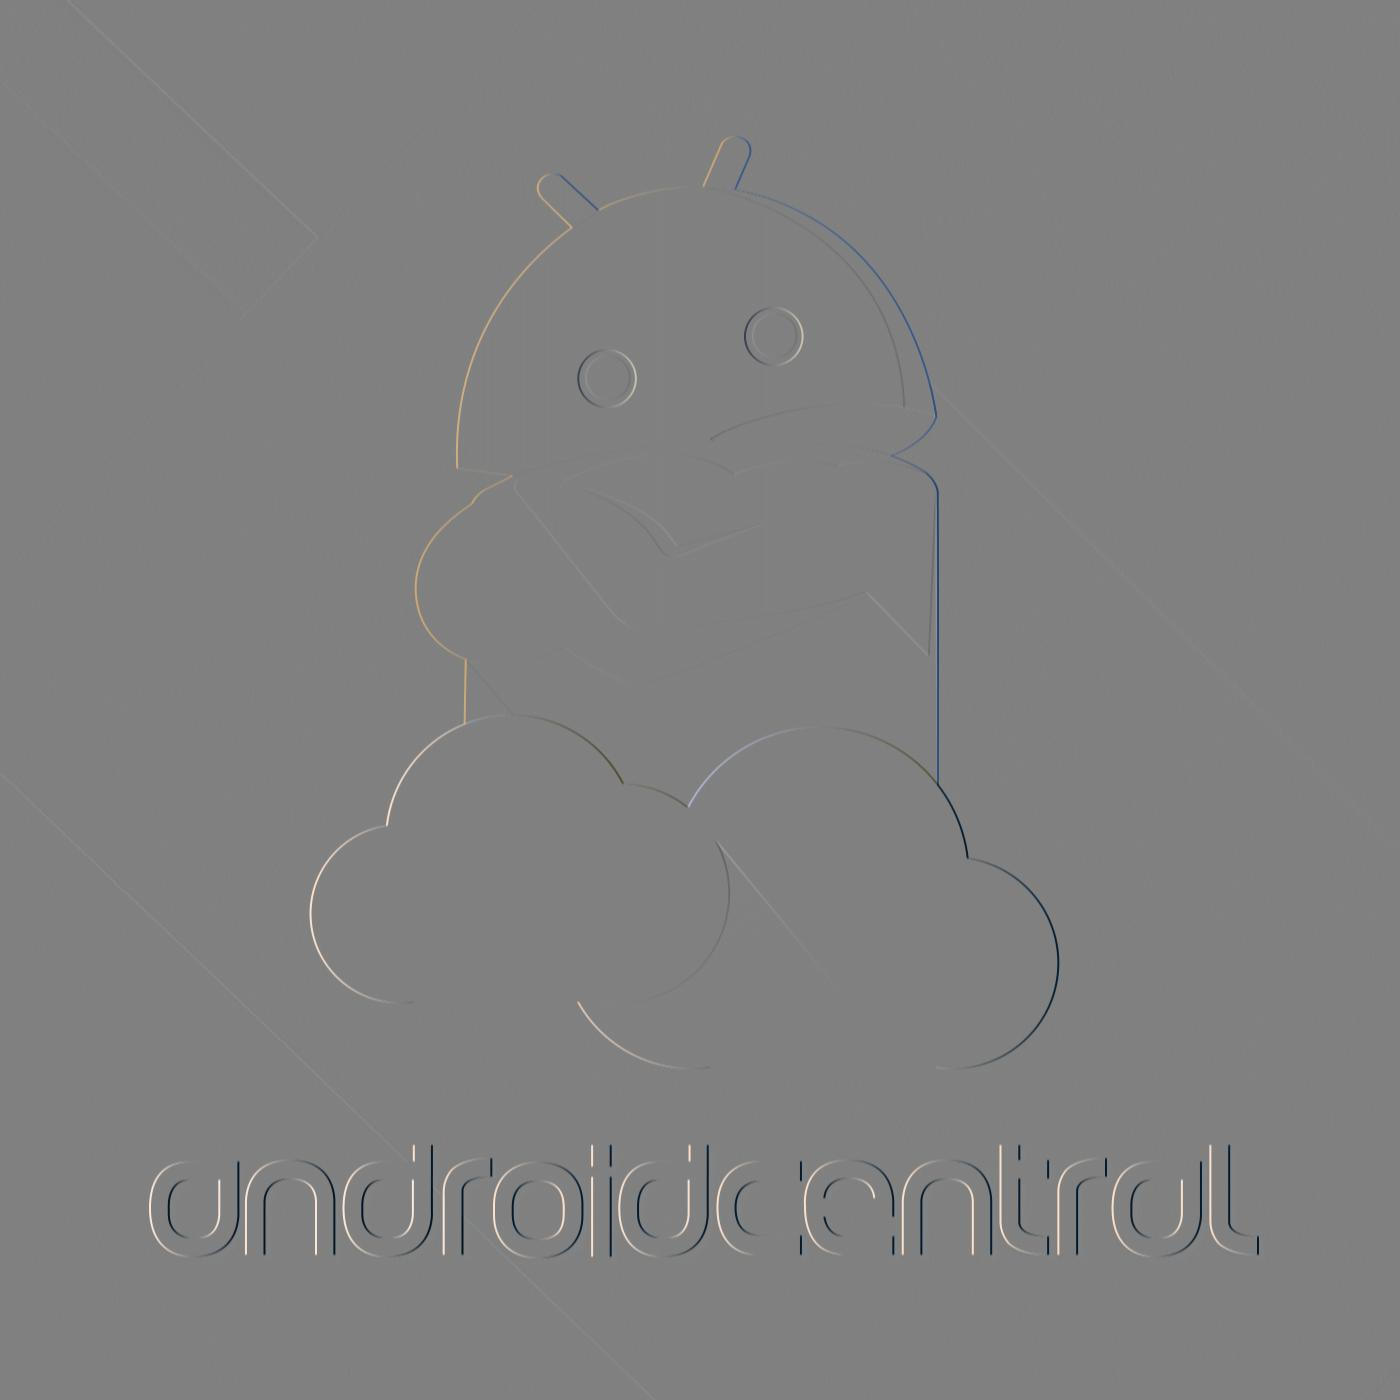

In [0]:
im = imageio.imread('android.jpg')
im = im.astype('int32')
dy = ndimage.sobel(im, 1)  # vertical derivative

display_img(dy)

If we combine the resulting images

In [0]:
mag = np.hypot(dx, dy)
mag *= 255.0 / np.max(mag)

And display the results

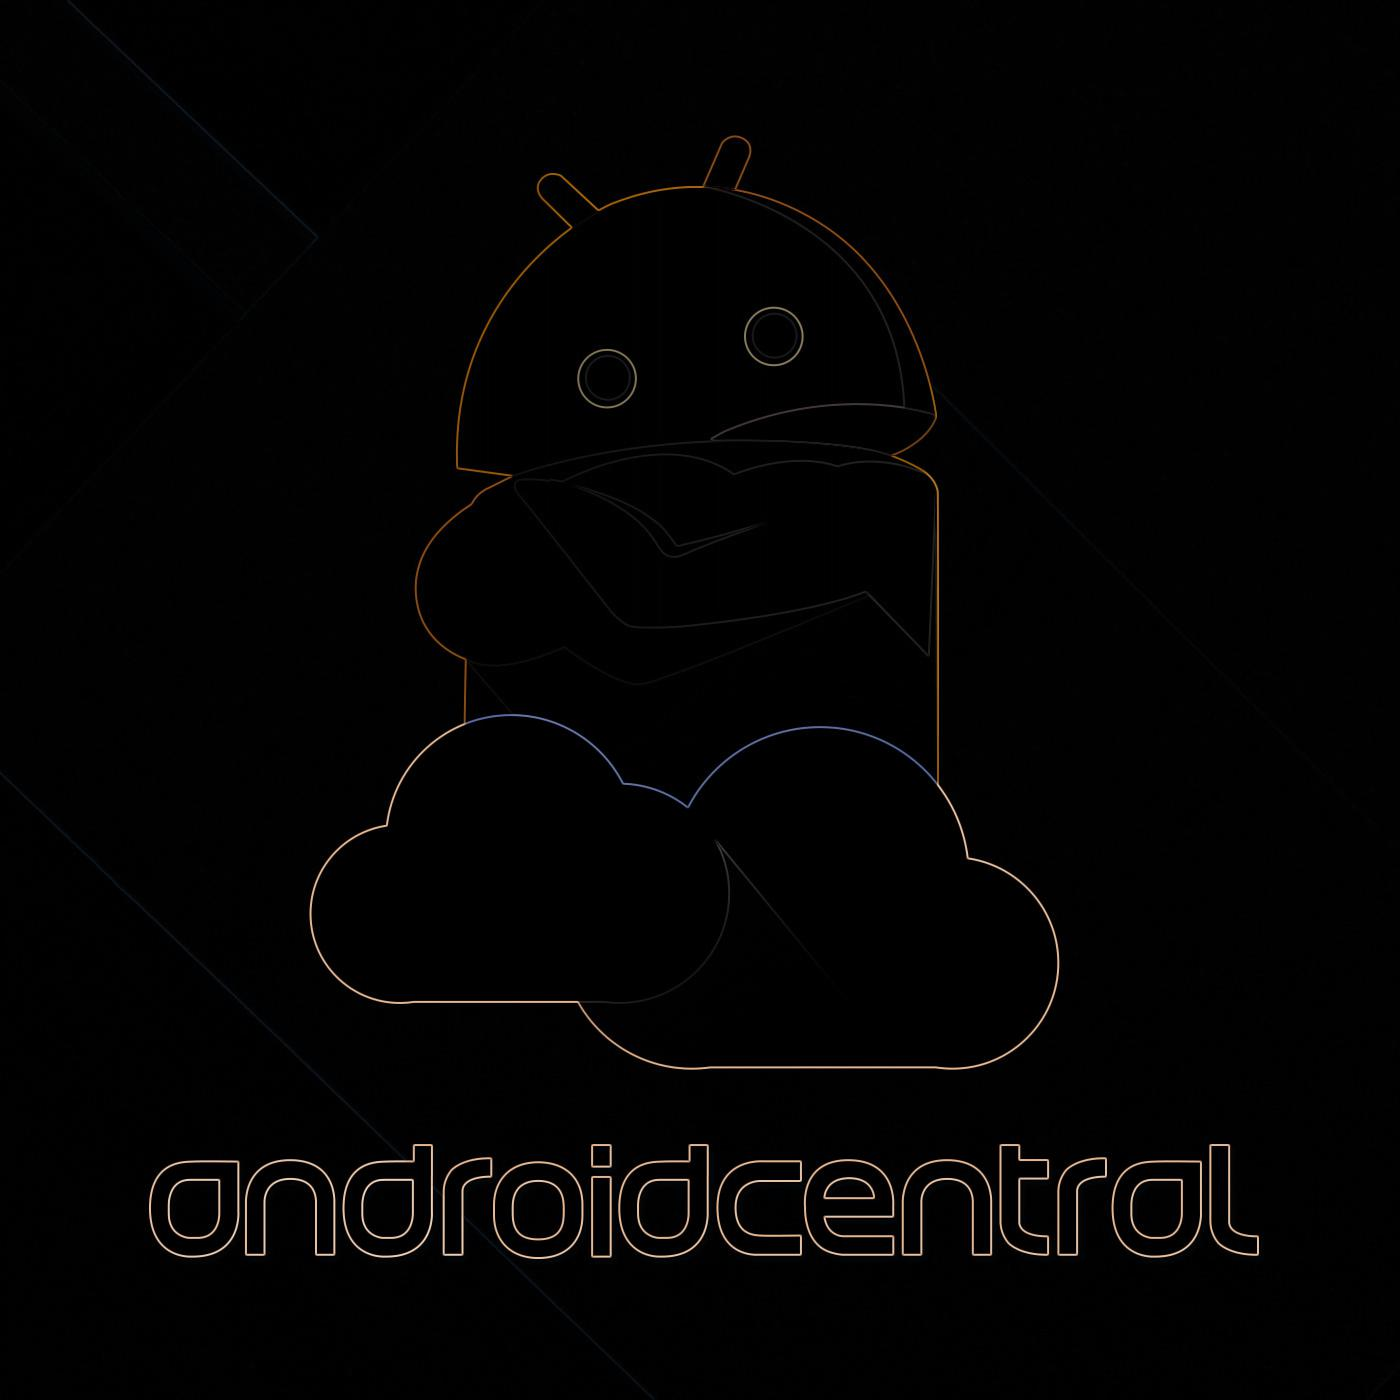

In [0]:
display_img(mag)

Note: The strongest edges are very clearly defined or directly horizontal/vertical, whilst the more diagonal or less obviously apparent lines are not as easily picked up by the filter. 

CNNs function by learning to generate these kinds of filters. The deeper layers of your CNN can isolate far more complex features using the extracted features from previous layers. The reality is that the internals of CNNs are more often far more complicated than this and a lot messier! But this example gives you a sample of the principle they're implementing.

# Implementing a CNN

Lots of tools exist for building and training CNNs.

For our purposes we'll be using two of the most popular machine learning libraries.

Keras provides a high level API for building and training neural networks whilst Tensorflow provides the machine learning backend. These are often used as fairly standard building blocks for many machine learning endeavours in Python and are an excellent starting point for those looking to learn how to build and use neural networks.

In [0]:
import keras
import tensorflow

We'll be using the MNIST dataset. A well known dataset consisting of single digit handwritten numbers. Our CNN will attempt to identify which number has been written.

In [0]:
from keras.datasets import mnist

Our first task is to create our training/testing set. Fortunately for pre-existing datasets on Keras they provide a built in split.

In [0]:

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Lets have a look at a sample image.

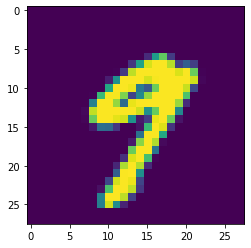

In [0]:
import matplotlib.pyplot as plt
plt.imshow(X_test[20])

The colour is a little odd because of how matplotlib prints images. Lets have a look at the shape of our data. This will help us figure out whether the images are colour or grayscale.

In [0]:
print(X_train.shape)

(60000, 28, 28)


Note, our 3 dimensions. The number of images, the width of our images and height of them. Our image does not have an extra dimensional channel for colour. However Keras requires that this be specified within the shape. So we'll explicitly outline a shape of 1 in the fourth dimension indicating the images are grayscale.

In [0]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000,28,28,1)
print(X_train.shape)

(60000, 28, 28, 1)


For our inputs we need to convert them to a "Neural network" friendly form. In this case we'll use what's known as one-hot encoding. Essentially each category is associated with a binary variable in the inputs and outputs. For example in the following example the 

In [0]:
from keras.utils import to_categorical

print("Training Category value: ", y_train[0])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("Converted Form:", y_train[0])

Training Category value:  5
Converted Form: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


We have our training data. Now we need to create a neural network to train. We instantiate a feedforward network with 2 convolution layers, with our first being composed of 64 filters and the second of 32. Notice the input shape matches the shape of a single instance of our training images.

Essentially what is happening here, is our second layer is taking the contents of our first layer and building bigger, more complicated feature maps out of the initial feature maps constructed.

We then flatten our results into a single dimensional layer that is passed to our fully connected layer. This layer is responsible for the use of the features detected to classify the image into one of our specified categories in the input.

This uses what is known as "softmax" activation. Essentially our end results will all be values from 0 to 1 where the sum is 1. We've turned our detections into probabilities!

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()

# Add our convolutional layers
model.add(Conv2D(64, kernel_size=3, activation='sigmoid', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())

# Add our classification layer, note 10 units. One for each possible digit.
model.add(Dense(10, activation='softmax'))

Time to fit our model!

We pass in our training and validation datasets and perform 3 passes across the full set of data.

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 170s 3ms/step - loss: 0.1404 - acc: 0.9585 - val_loss: 0.1123 - val_acc: 0.9664
Epoch 2/3
60000/60000 [==============================] - 170s 3ms/step - loss: 0.0620 - acc: 0.9808 - val_loss: 0.0657 - val_acc: 0.9783
Epoch 3/3
60000/60000 [==============================] - 169s 3ms/step - loss: 0.0437 - acc: 0.9866 - val_loss: 0.0715 - val_acc: 0.9789


If correctly implemented this should produce a val_acc of greater than 0.9. This means our accuracy against our validation set is greater than 90%! Given we have our model we can test it further! Let's try calculating a value from our test set. 

Given our model produces probabilities we'll extract the highest probability value and call that the prediction the model produced. We can then compare it to our initial values.

In [0]:
import numpy as np

def get_category(arr, index):
  
  iter_vals = arr[index]

  max_val = 0
  max_val_idx = 0
  for idx, val in enumerate(iter_vals):
    if val > max_val:
      max_val = val
      max_val_idx = idx
  
  return max_val_idx




def test_value(model, X_test, y_test, index_to_check):
  predicted_probabilities = model.predict(X_test[index_to_check:index_to_check+1])
  actual_value = get_category(y_test, index_to_check)
  predicted_value = get_category(predicted_probabilities, 0)

  # print(predicted_probabilities)
  # print(y_test[20])


  return (actual_value, predicted_value)


print(test_value(model, X_test, y_test, 20))
print(test_value(model, X_test, y_test, 21))
print(test_value(model, X_test, y_test, 22))
print(test_value(model, X_test, y_test, 23))

(9, 9)
(6, 6)
(6, 6)
(5, 5)


We've got a modelthat can make predictions!

# Testing Performance of Model

There are a wide variety of ways to test a convolutional neural network. The easiest and most obvious way is to predict the results of every value in our test set then check 

In [0]:
accurate_predictions=0
no_to_check=5000

for i in range(0, no_to_check):
  result = test_value(model, X_test, y_test, i)
  print(result[0], result[1])
  if(result[0] == result[1]):
    accurate_predictions+=1

print(accurate_predictions/no_to_check)

7 7
2 2
1 1
0 0
4 4
1 1
4 4
9 9
5 5
9 9
0 0
6 6
9 9
0 0
1 1
5 5
9 9
7 7
3 3
4 4
9 9
6 6
6 6
5 5
4 4
0 0
7 7
4 4
0 0
1 1
3 3
1 1
3 3
4 4
7 7
2 2
7 7
1 1
2 2
1 1
1 1
7 7
4 4
2 2
3 3
5 5
1 1
2 2
4 4
4 4
6 6
3 3
5 5
5 5
6 6
0 0
4 4
1 1
9 9
5 5
7 7
8 8
9 9
3 3
7 7
4 4
6 6
4 4
3 3
0 0
7 7
0 0
2 2
9 9
1 1
7 7
3 3
2 2
9 9
7 7
7 7
6 6
2 2
7 7
8 8
4 4
7 7
3 3
6 6
1 1
3 3
6 6
9 9
3 3
1 1
4 4
1 1
7 7
6 6
9 9
6 6
0 0
5 5
4 4
9 9
9 9
2 2
1 1
9 9
4 4
8 8
7 7
3 3
9 9
7 7
4 4
4 4
4 4
9 9
2 2
5 5
4 4
7 7
6 6
7 7
9 9
0 0
5 5
8 8
5 5
6 6
6 6
5 5
7 7
8 8
1 1
0 0
1 1
6 6
4 4
6 6
7 7
3 3
1 1
7 7
1 1
8 8
2 2
0 0
2 2
9 9
9 9
5 5
5 5
1 1
5 5
6 6
0 0
3 3
4 4
4 4
6 6
5 5
4 4
6 6
5 5
4 4
5 5
1 1
4 4
4 4
7 7
2 2
3 3
2 2
7 7
1 1
8 8
1 1
8 8
1 1
8 8
5 5
0 0
8 8
9 9
2 2
5 5
0 0
1 1
1 1
1 1
0 0
9 9
0 0
3 3
1 1
6 6
4 4
2 3
3 3
6 6
1 1
1 1
1 1
3 3
9 9
5 5
2 2
9 9
4 4
5 5
9 9
3 3
9 9
0 0
3 3
6 5
5 5
5 5
7 7
2 2
2 2
7 7
1 1
2 2
8 8
4 4
1 1
7 7
3 3
3 3
8 8
8 8
7 7
9 9
2 2
2 2
4 4
1 1
5 5
9 9
8 8
7 2
2 2
3 3
0 0
4 4
4 4
2 2


Of course this is very rudimentary and there are plenty more far more rigorous ways to test your system. In particular including both a validation and testing set can ensure you're not overfitting your model to your current set (i.e. training just for your validation set). K-fold cross validation can test for the general functionality of your model more broadly.

What I'm swinging at, is there's lots of different ways to investigate CNNs with a massive number of resources out there that you can tap into. They're an awesome piece of technology that I highly recommend playing around with.